## Import

In [1]:
import os
import cv2
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\IT\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utils

In [2]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Custom Dataset

In [3]:
class SatelliteDataset_img(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return 535500

    def __getitem__(self, idx):
        #img_path = self.data.iloc[idx, 1]
        if idx >= 178500 and idx < 357000:
            mask_idx = idx - 178500
        elif idx >= 357000:
            mask_idx = idx - 357000
        else:
            mask_idx = idx
        img_path = f"C:\\Users\\IT\\Desktop\\open\\train_img\\TRAIN_{idx:04d}.png"
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        #mask_rle = self.data.iloc[idx, 2]
        mask_rle = f"C:\\Users\\IT\\Desktop\\open\\mask_train\\mask_{mask_idx:04d}.png"
        #mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))
        mask = cv2.imread(mask_rle)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)
        
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask
    
class SatelliteDataset_test(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))
        
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

## Data Loader

In [4]:
transform = A.Compose(
    [   
        #A.Resize(224, 224),
        A.Normalize(),
        ToTensorV2()
    ]
)

dataset = SatelliteDataset_img(csv_file='./train.csv', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

C:\Users\IT\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:9: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  if __name__ == "__main__":
C:\Users\IT\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == "__main__":
Clipping input data to the valid range for imshow with R

torch.Size([3, 224, 224])


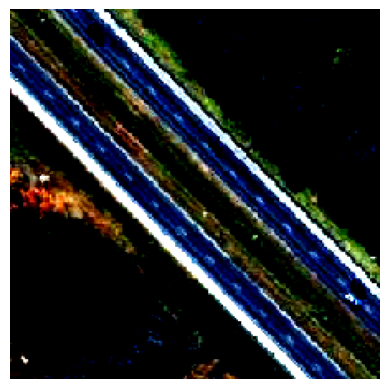

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


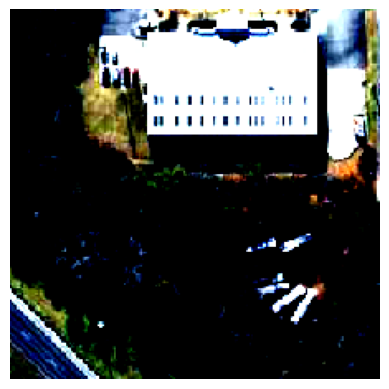

torch.Size([224, 224])


C:\Users\IT\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:31: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
C:\Users\IT\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


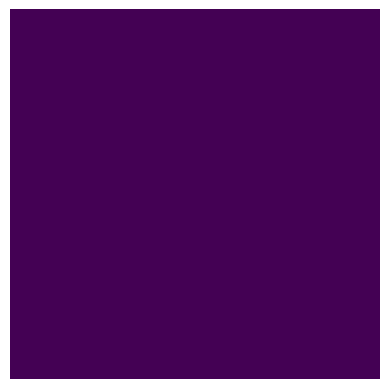

torch.Size([224, 224])


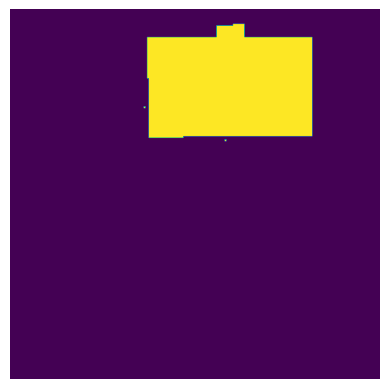

In [24]:
import matplotlib.pyplot as plt

images = []
for i in range(178500, 178502):
    image, mask = dataset[i]
    images.append(image)

# 리스트를 numpy 배열로 변환
images = np.array(images)

# 이미지 시각화 함수
def imshow(image):
    image = np.transpose(image, (1, 2, 0))  # (채널, 높이, 너비) -> (높이, 너비, 채널)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


# 이미지 시각화
for i in range(2):
    image = images[i]
    print(image.shape)
    imshow(image)

images = []
for i in range(357000, 357002):
    image, mask = dataset[i]
    images.append(mask)

# 리스트를 numpy 배열로 변환
images = np.array(images)

# 이미지 시각화 함수
def imshow(image):
    #image = np.transpose(image, (1, 2, 0))  # (채널, 높이, 너비) -> (높이, 너비, 채널)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


# 이미지 시각화
for i in range(2):
    image = images[i]
    print(image.shape)
    imshow(image)


In [27]:
# 데이터셋 길이 확인
print("Dataset length:", len(dataset))

# 데이터셋 예제 중 하나의 딕셔너리 확인
example_index = 178500
data_dict = dataset[example_index]
print("dict len :", len(data_dict[0][0]))
# 데이터셋 예제의 딕셔너리 구조 출력
print("Example", example_index, "dictionary:")
print(data_dict)

Dataset length: 357000
dict len : 224
Example 178500 dictionary:
(tensor([[[-0.3198, -0.5596, -0.5082,  ..., -1.1932, -0.9020, -1.1075],
         [ 0.3309,  0.1426, -0.0801,  ..., -1.1075, -0.5938, -0.6623],
         [ 0.3309,  0.4508,  0.3481,  ..., -0.7650, -0.4568, -0.5596],
         ...,
         [ 0.1254,  0.0741,  0.0741,  ..., -0.2856, -0.3198, -0.3198],
         [ 0.0056, -0.0287, -0.0629,  ...,  0.2796, -0.2171, -0.3883],
         [ 0.0398, -0.0116, -0.0287,  ...,  0.3823, -0.0116, -0.1828]],

        [[-0.0574, -0.3375, -0.2675,  ..., -1.0903, -0.7927, -1.0028],
         [ 0.3277,  0.1702, -0.0399,  ..., -1.0028, -0.4776, -0.5476],
         [ 0.3277,  0.4678,  0.3627,  ..., -0.6527, -0.3375, -0.4426],
         ...,
         [-0.0399, -0.0924, -0.0924,  ..., -0.1800, -0.1975, -0.1800],
         [-0.1625, -0.1975, -0.2150,  ...,  0.3978, -0.1099, -0.2850],
         [-0.1275, -0.1800, -0.1975,  ...,  0.5028,  0.1001, -0.0924]],

        [[-0.4275, -0.6193, -0.5147,  ..., -0.8633

In [15]:
# 데이터셋 길이 확인
print("Dataset length:", len(dataset))

# 이미지와 마스크 데이터의 구조 출력
for idx in range(len(dataset)):
    data = dataset[idx]
    if len(data) == 1:
        print(f"Example {idx}: Image data")
        print("Image shape:", data.shape)
    else:
        image, mask = data
        print(f"Example {idx}: Image and Mask data")
        print("Image shape:", image.shape)
        print("Mask shape:", mask.shape)

Dataset length: 178500
Example 0: Image and Mask data
Image shape: torch.Size([3, 224, 224])
Mask shape: torch.Size([224, 224])
Example 1: Image and Mask data
Image shape: torch.Size([3, 224, 224])
Mask shape: torch.Size([224, 224])
Example 2: Image and Mask data
Image shape: torch.Size([3, 224, 224])
Mask shape: torch.Size([224, 224])
Example 3: Image and Mask data
Image shape: torch.Size([3, 224, 224])
Mask shape: torch.Size([224, 224])
Example 4: Image and Mask data
Image shape: torch.Size([3, 224, 224])
Mask shape: torch.Size([224, 224])
Example 5: Image and Mask data
Image shape: torch.Size([3, 224, 224])
Mask shape: torch.Size([224, 224])
Example 6: Image and Mask data
Image shape: torch.Size([3, 224, 224])
Mask shape: torch.Size([224, 224])
Example 7: Image and Mask data
Image shape: torch.Size([3, 224, 224])
Mask shape: torch.Size([224, 224])
Example 8: Image and Mask data
Image shape: torch.Size([3, 224, 224])
Mask shape: torch.Size([224, 224])
Example 9: Image and Mask data
I

KeyboardInterrupt: 

## Define Model

In [5]:
# U-Net의 기본 구성 요소인 Double Convolution Block을 정의합니다.
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

# 간단한 U-Net 모델 정의
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)
        self.dconv_down5 = double_conv(512, 1024)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        

        self.dconv_up4 = double_conv(512 + 1024, 512)
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4)      

        x = self.dconv_down5(x)

        x = self.upsample(x)        
        x = torch.cat([x, conv4], dim=1)

        x = self.dconv_up4(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1) 

        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

## Model Train

In [6]:
# model 초기화
model = UNet().to(device)

# loss function과 optimizer 정의
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# patience = 1
# # training loop

# best_loss = float('inf')
# early_stop_count = 0

for epoch in range(2):  # 10 에폭 동안 학습합니다.
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(dataloader):
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader)}')

    # if epoch_loss < best_loss:
    #     best_loss = epoch_loss
    #     early_stop_count = 0
    # else:
    #     early_stop_count += 1
    
    # if early_stop_count >= patience:
    #     print("Early stopping triggered!")
    #     break


100%|██████████| 33469/33469 [3:58:48<00:00,  2.34it/s]  


Epoch 1, Loss: 0.08952961837282776


100%|██████████| 33469/33469 [3:58:32<00:00,  2.34it/s]  

Epoch 2, Loss: 0.06987432544426164


## Inference

In [7]:
# 여기서부터 실행해줘~

test_dataset = SatelliteDataset_test(csv_file='./test.csv', transform=transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

In [17]:
with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)
        
        outputs = model(images)
        masks = torch.sigmoid(outputs).cpu().numpy()
        masks = np.squeeze(masks, axis=1)
        masks = (masks > 0.35).astype(np.uint8) # Threshold = 0.35
        
        for i in range(len(images)):
            mask_rle = rle_encode(masks[i])
            if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                result.append(-1)
            else:
                result.append(mask_rle)

100%|██████████| 3790/3790 [11:51<00:00,  5.33it/s]


## Submission

In [19]:
submit = pd.read_csv('./sample_submission.csv')
submit['mask_rle'] = result

In [20]:
submit.to_csv('./submit.csv', index=False)

In [21]:
class SatelliteDataset1(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        mask_rle = self.data.iloc[idx, 1]
        mask = rle_decode(mask_rle, (224, 224))
        return mask

In [22]:
dataset = SatelliteDataset1(csv_file='./submit.csv', transform=transform)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


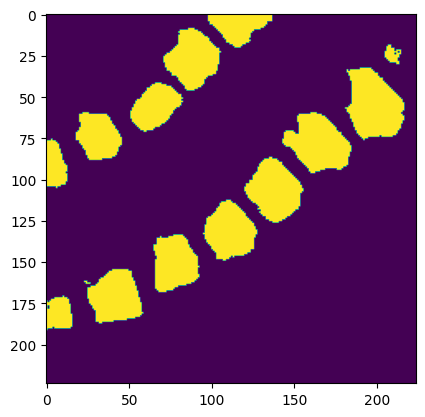

In [31]:
import matplotlib.pyplot as plt
example_index = 52682
data_dict = dataset[example_index]

img_t1 = data_dict
print(img_t1)
plt.imshow(img_t1)
plt.show()